<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [7]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [9]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Посмотрим на какую-нибудь картинку:

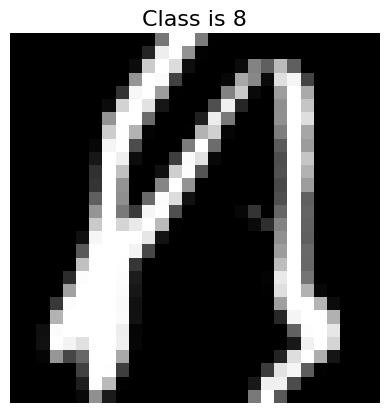

In [15]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [11]:
#checking unique classes
classes = []
for i in range(len(trainset)):
    classes.append(trainset[i][1])
unique_classes = np.unique(np.array(classes))
unique_classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

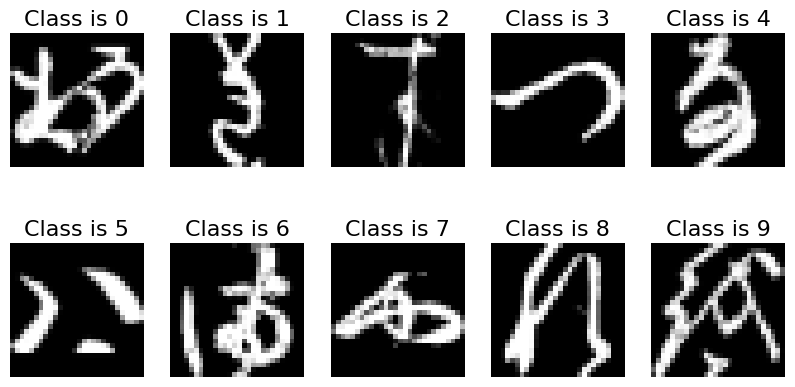

In [27]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in unique_classes:
    c = 0
    while trainset[c][1] != i:
        c += 1
    ax[i//5][i%5].imshow(trainset[c][0].view(28, 28).numpy(), cmap="gray")
    ax[i//5][i%5].axis("off")
    ax[i//5][i%5].set_title(f"Class is {trainset[c][1]}", fontsize=16);

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [102]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self, func=None):
        super().__init__() #  это надо помнить!
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.func = func
        
    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)

        return logits

In [36]:
28*28*256 + 256*128 + 128*10

234752

In [37]:
256 + 128 + 10

394

In [38]:
234752+394

235146

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

весов 234752

смещений 394

параметров 235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [56]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [57]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [58]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6866
Epoch=2 loss=0.3020
Epoch=3 loss=0.2254
Epoch=4 loss=0.1763
Epoch=5 loss=0.1406
Epoch=6 loss=0.1147
Epoch=7 loss=0.0931
Epoch=8 loss=0.0764
Epoch=9 loss=0.0622
Epoch=10 loss=0.0502
CPU times: user 30.5 s, sys: 2.07 s, total: 32.6 s
Wall time: 2min 43s


In [59]:
get_accuracy(fc_net, testloader)

0.8974

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [60]:
mean = torch.mean(trainset.data.view(-1, 28*28*60000)/255) ## calculate mean
std = torch.std(trainset.data.view(-1, 28*28*60000)/255) ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [61]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [62]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")



Epoch=1 loss=0.6914
Epoch=2 loss=0.3044
Epoch=3 loss=0.2262
Epoch=4 loss=0.1753
Epoch=5 loss=0.1421
Epoch=6 loss=0.1130
Epoch=7 loss=0.0928
Epoch=8 loss=0.0760
Epoch=9 loss=0.0622
Epoch=10 loss=0.0508
CPU times: user 30.4 s, sys: 2.17 s, total: 32.5 s
Wall time: 2min 35s


In [63]:
get_accuracy(fc_net, testloader)

0.8997

Как изменилась `accuracy` после нормализации?

увеличилась

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

#### Sigmoid

In [64]:
class FCNet_Sigmoid(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        logits = self.fc3(x)

        return logits

In [65]:
# Создадим объект модели
fc_net_Sigmoid = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net_Sigmoid.parameters(), lr=3e-4)

In [66]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_Sigmoid(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")



Epoch=1 loss=0.6924
Epoch=2 loss=0.3039
Epoch=3 loss=0.2235
Epoch=4 loss=0.1759
Epoch=5 loss=0.1384
Epoch=6 loss=0.1128
Epoch=7 loss=0.0925
Epoch=8 loss=0.0759
Epoch=9 loss=0.0630
Epoch=10 loss=0.0504
CPU times: user 30.7 s, sys: 2.14 s, total: 32.8 s
Wall time: 3min 3s


In [68]:
get_accuracy(fc_net_Sigmoid, testloader)

0.896

#### GELU

In [69]:
class FCNet_GELU(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        logits = self.fc3(x)

        return logits

In [70]:
# Создадим объект модели
fc_net_GELU = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net_GELU.parameters(), lr=3e-4)

In [71]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_GELU(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6822
Epoch=2 loss=0.3011
Epoch=3 loss=0.2228
Epoch=4 loss=0.1741
Epoch=5 loss=0.1388
Epoch=6 loss=0.1140
Epoch=7 loss=0.0923
Epoch=8 loss=0.0757
Epoch=9 loss=0.0617
Epoch=10 loss=0.0503
CPU times: user 30.8 s, sys: 2.17 s, total: 33 s
Wall time: 2min 56s


In [72]:
get_accuracy(fc_net_GELU, testloader)

0.8983

#### Tanh

In [73]:
class FCNet_Tanh(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        logits = self.fc3(x)

        return logits

In [74]:
# Создадим объект модели
fc_net_Tanh = FCNet_Tanh()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net_Tanh.parameters(), lr=3e-4)

In [75]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_Tanh(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.7766
Epoch=2 loss=0.3812
Epoch=3 loss=0.2570
Epoch=4 loss=0.1836
Epoch=5 loss=0.1348
Epoch=6 loss=0.1018
Epoch=7 loss=0.0761
Epoch=8 loss=0.0572
Epoch=9 loss=0.0435
Epoch=10 loss=0.0310
CPU times: user 31.8 s, sys: 2.14 s, total: 33.9 s
Wall time: 2min 38s


In [76]:
get_accuracy(fc_net_Tanh, testloader)

0.8969

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

GELU

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

#### Adam

In [86]:
optimizer = torch.optim.Adam(fc_net_GELU.parameters(), lr=3e-4)

In [87]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_GELU(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.0432
Epoch=2 loss=0.0331
Epoch=3 loss=0.0249
Epoch=4 loss=0.0196
Epoch=5 loss=0.0149
Epoch=6 loss=0.0120
Epoch=7 loss=0.0079
Epoch=8 loss=0.0063
Epoch=9 loss=0.0044
Epoch=10 loss=0.0036
CPU times: user 30.8 s, sys: 2.16 s, total: 32.9 s
Wall time: 2min 37s


In [88]:
get_accuracy(fc_net_GELU, testloader)

0.8986

#### RMSprop

In [89]:
optimizer = torch.optim.RMSprop(fc_net_GELU.parameters(), lr=3e-4)

In [90]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_GELU(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.0187
Epoch=2 loss=0.0084
Epoch=3 loss=0.0057
Epoch=4 loss=0.0076
Epoch=5 loss=0.0052
Epoch=6 loss=0.0076
Epoch=7 loss=0.0034
Epoch=8 loss=0.0063
Epoch=9 loss=0.0043
Epoch=10 loss=0.0025
CPU times: user 28.4 s, sys: 2.14 s, total: 30.6 s
Wall time: 2min 36s


In [91]:
get_accuracy(fc_net_GELU, testloader)

0.9022

#### Adagrad

In [92]:
optimizer = torch.optim.Adagrad(fc_net_GELU.parameters(), lr=3e-4)

In [93]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_GELU(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.0005
Epoch=2 loss=0.0004
Epoch=3 loss=0.0003
Epoch=4 loss=0.0003
Epoch=5 loss=0.0003
Epoch=6 loss=0.0003
Epoch=7 loss=0.0003
Epoch=8 loss=0.0003
Epoch=9 loss=0.0003
Epoch=10 loss=0.0002
CPU times: user 28.2 s, sys: 2.2 s, total: 30.4 s
Wall time: 2min 41s


In [94]:
get_accuracy(fc_net_GELU, testloader)

0.9037

Лучше всего Adagrad

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [96]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0
        
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [103]:
# Создадим объект модели
fc_net = FCNet(func=CustomReLU())
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [104]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6824
Epoch=2 loss=0.2995
Epoch=3 loss=0.2227
Epoch=4 loss=0.1725
Epoch=5 loss=0.1382
Epoch=6 loss=0.1113
Epoch=7 loss=0.0917
Epoch=8 loss=0.0757
Epoch=9 loss=0.0607
Epoch=10 loss=0.0503
CPU times: user 30.5 s, sys: 2.23 s, total: 32.7 s
Wall time: 2min 45s


In [105]:
get_accuracy(fc_net, testloader)

0.8966

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

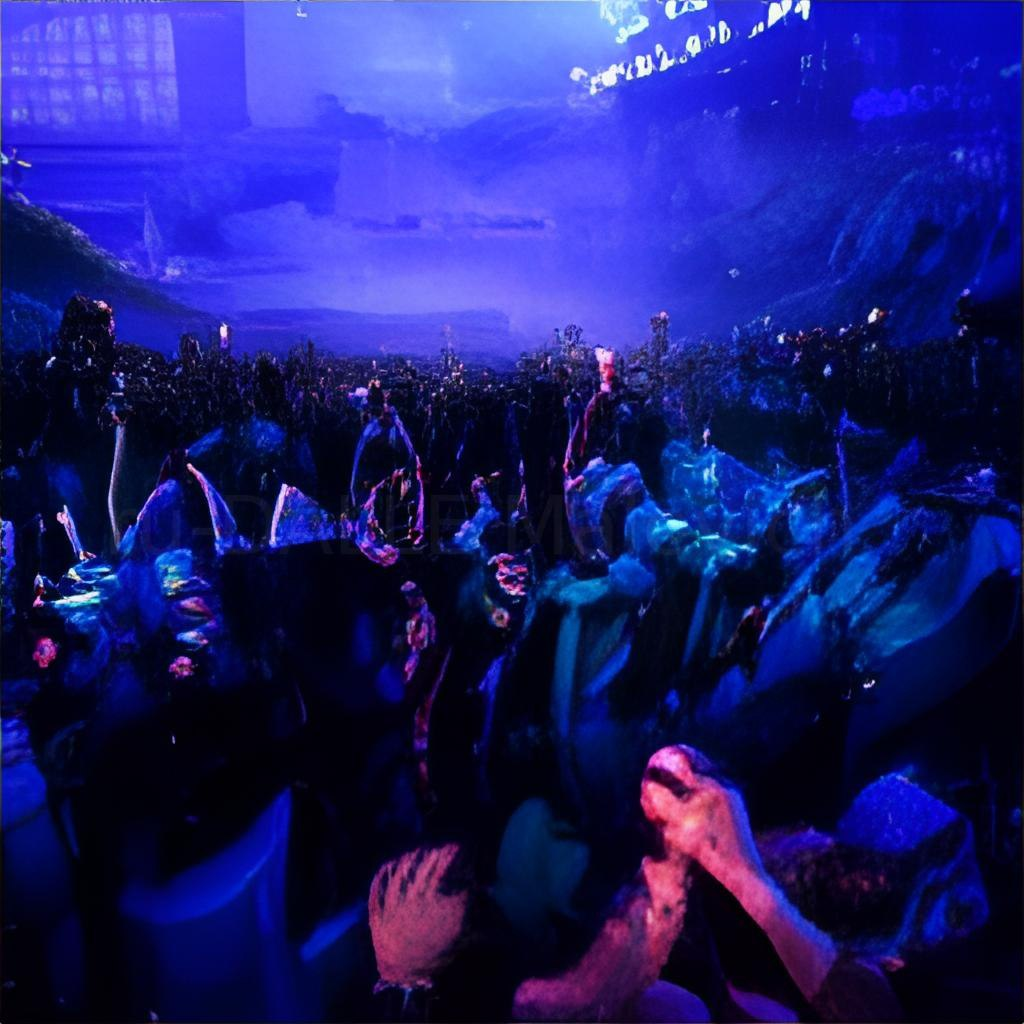

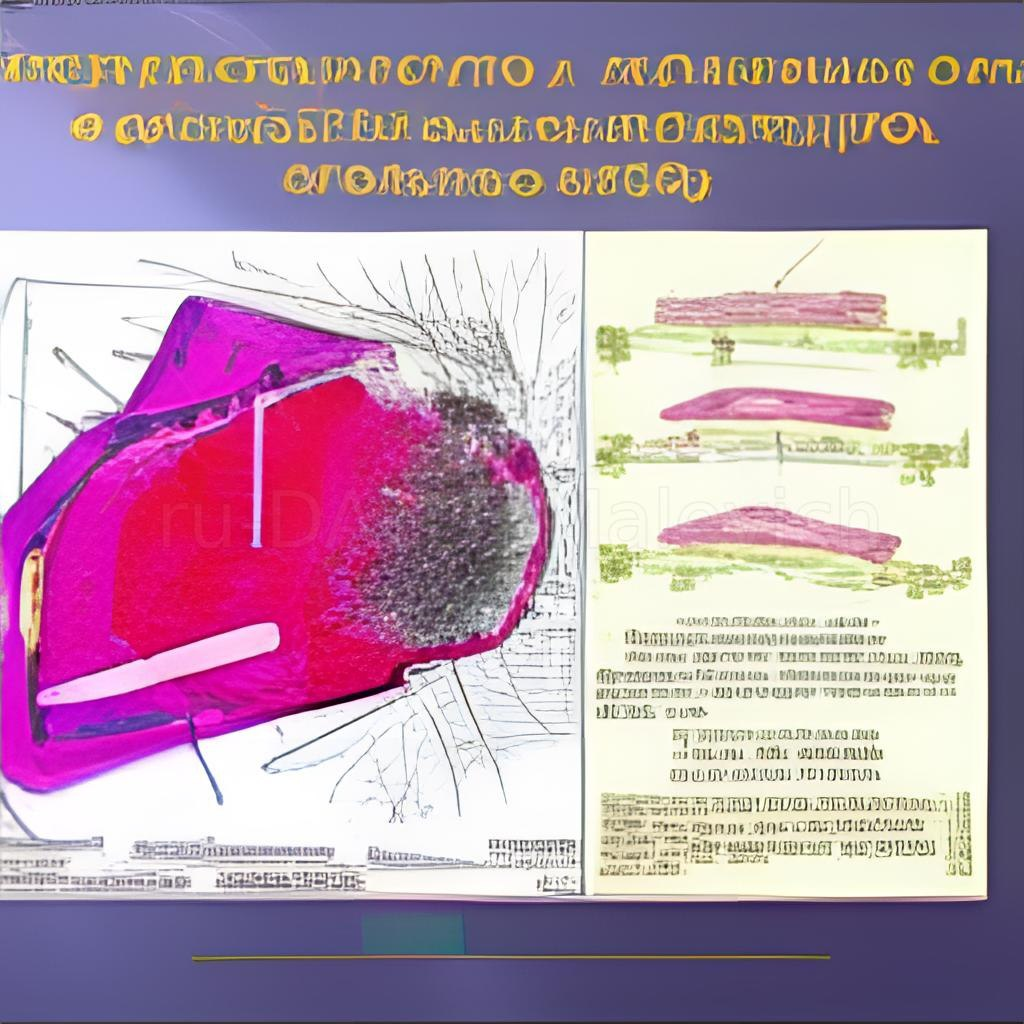

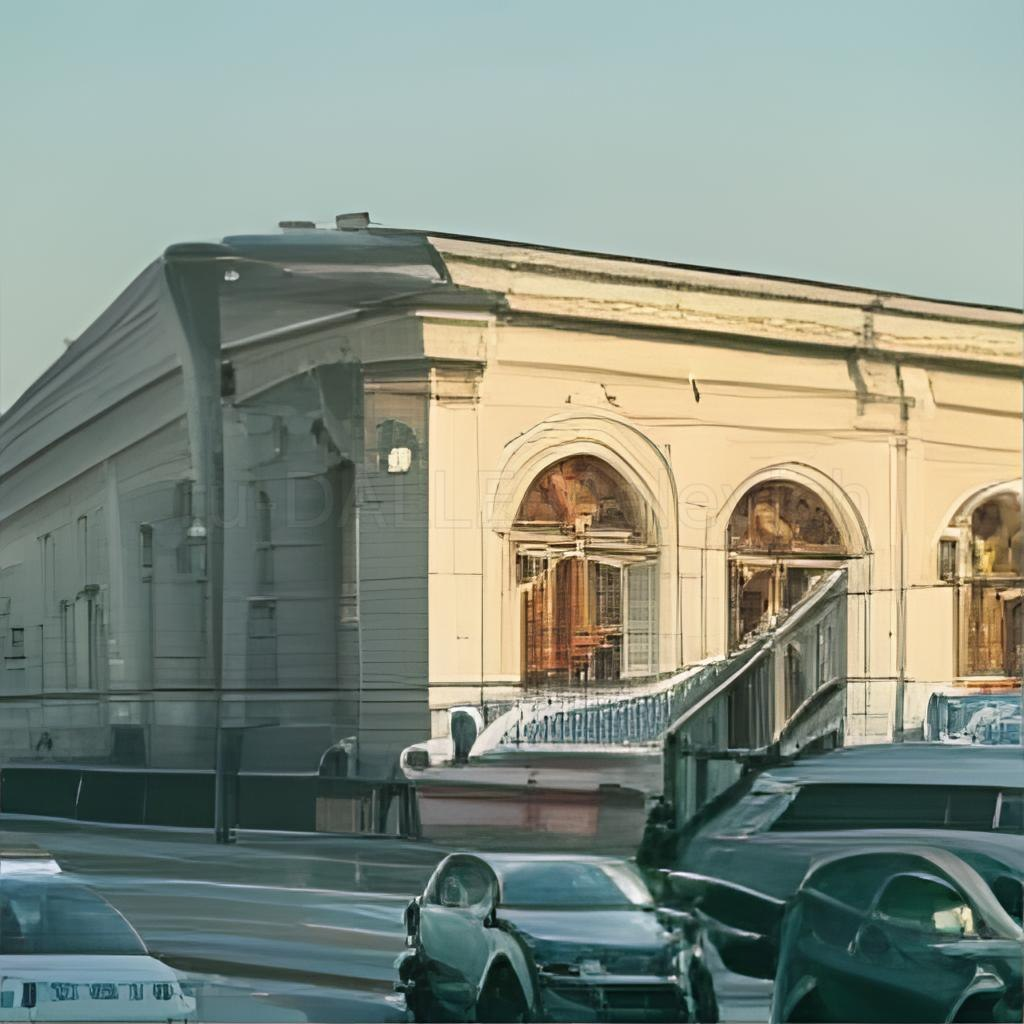